In [ ]:
Author: Ujwal Watgule
Contribution: This notebook demonstrates how to use DEAP (Distributed Evolutionary Algorithms in Python)
for hyperparameter optimization in machine learning.

In [ ]:
# 1. Introduction
Evolutionary algorithms in DEAP can optimize machine learning hyperparameters more efficiently than grid/random search,
especially in high-dimensional spaces. 

This tutorial shows how to:

1. Set up a genetic algorithm (GA) in DEAP.

2. Optimize a RandomForestClassifier from scikit-learn.

3. Visualize the optimization process.

Key Features Demonstrated:
    
1. Custom fitness evaluation
2. Evolutionary operators (selection, crossover, mutation)
3. Statistical tracking and visualization

In [1]:
#2. Setup
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

# Load Data

data = load_iris()
X, y = data.data, data.target
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")

Dataset: 150 samples, 4 features


In [2]:
# 3. Problem Definition
# Goal: Optimize two hyperparameters for RandomForestClassifier:
    
def ensure_valid_params(individual):
    """Ensure n_estimators and max_depth stay within valid ranges"""
    n_estimators = max(1, int(individual[0]))  # At least 1 tree
    max_depth = max(1, int(individual[1]))     # At least depth 1
    return [n_estimators, max_depth]


In [5]:
# 4. DEAP Implementation
# Step 4.1: Define Fitness and Individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Step 4.2: Initialize Toolbox
toolbox = base.Toolbox()

# Initialize with valid ranges
toolbox.register("attr_n_est", np.random.randint, 10, 200)  # 10-200 trees
toolbox.register("attr_depth", np.random.randint, 2, 20)    # Depth 2-20
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_est, toolbox.attr_depth), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Step 4.3: Register Evolutionary Operators

# Evolutionary operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


# Step 4.4: Define Fitness Evaluation

def evaluate(individual):
    # Apply constraints first
    n_estimators, max_depth = ensure_valid_params(individual)
    
    try:
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
        score = cross_val_score(model, X, y, cv=3).mean()
        return (score,)
    except Exception as e:
        # Return worst possible score if error occurs
        return (0.0,)
    
toolbox.register("evaluate", evaluate)

In [6]:
# 5. Run the Evolutionary Algorithm
# Step 5.1: Initialize Population and Statistics

population = toolbox.population(n=50)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

# KEY FIX: Add halloffame to track best individual
hof = tools.HallOfFame(1)

# Step 5.2: Evolve!
result, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=20,
    stats=stats, halloffame=hof, verbose=True
)


# Step 5.3: Extract Best Solution

best_individual = hof[0]
valid_params = ensure_valid_params(best_individual)
print(f"Best hyperparameters: n_estimators={valid_params[0]}, max_depth={valid_params[1]}")
print(f"Best accuracy: {best_individual.fitness.values[0]:.4f}")

gen	nevals	avg     	max     
0  	50    	0.964533	0.966667
1  	43    	0.964   	0.966667
2  	41    	0.966   	0.966667
3  	43    	0.966267	0.966667
4  	29    	0.966533	0.966667
5  	38    	0.9664  	0.966667
6  	41    	0.966667	0.966667
7  	34    	0.966667	0.966667
8  	40    	0.965467	0.966667
9  	36    	0.965867	0.966667
10 	40    	0.966267	0.966667
11 	44    	0.966   	0.966667
12 	40    	0.965867	0.966667
13 	38    	0.965467	0.966667
14 	35    	0.965733	0.966667
15 	41    	0.966   	0.966667
16 	40    	0.966667	0.966667
17 	37    	0.966   	0.966667
18 	36    	0.966667	0.966667
19 	28    	0.9664  	0.966667
20 	36    	0.965067	0.966667
Best hyperparameters: n_estimators=199, max_depth=19
Best accuracy: 0.9667


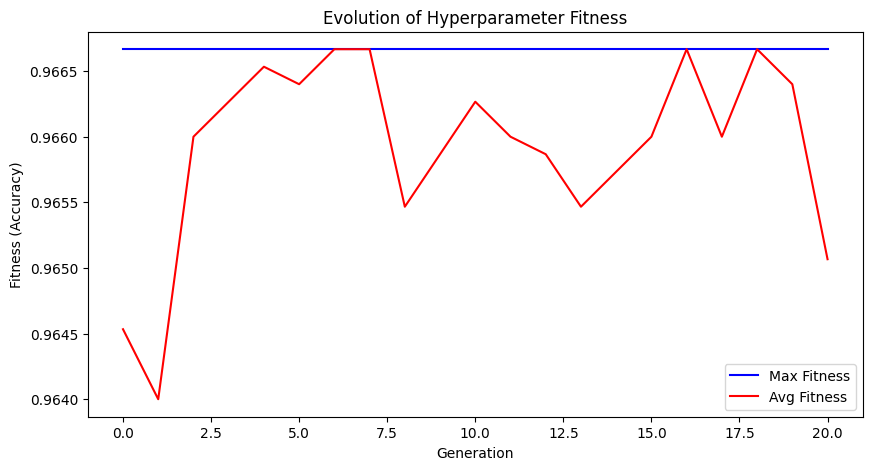

In [7]:
# 6. Visualization
# Plot Fitness Over Generations

gen = logbook.select("gen")
fit_max = logbook.select("max")
fit_avg = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, fit_max, "b-", label="Max Fitness")
plt.plot(gen, fit_avg, "r-", label="Avg Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.title("Evolution of Hyperparameter Fitness")
plt.legend()
plt.show()